# Lecture 26: Stochastic Gradient Descent
***

We'll need Numpy, Matplotlib, Pandas, and scipy.stats for this notebook, so let's load them.

In [23]:
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pylab as plt 
import statsmodels.api as sm
%matplotlib inline

### Exercise 1: Stochastic Gradient Descent for Simple Linear Regression 
***

**Note**: There are some helper functions at the bottom of this notebook.  Scroll down and evaluate those before proceeding. 

In this exercise we will implement Stochastic Gradient Descent to learn the parameters of a simple linear regression.  We'll use data randomly generated from the model $Y = 1 + 2X + \epsilon$ where $\epsilon \sim N(0,1)$. The following code will generate and plot the data. 

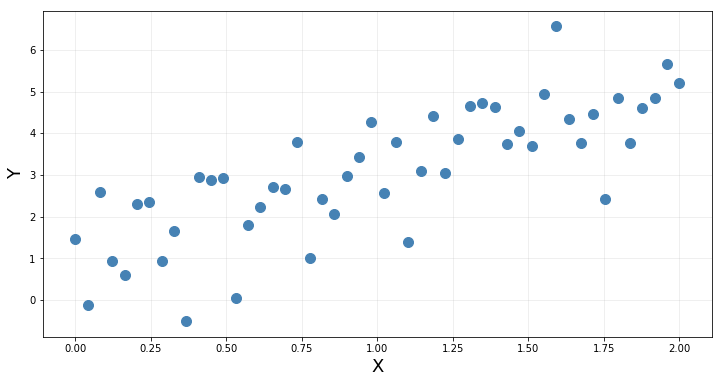

In [143]:
np.random.seed(1234)
x = np.linspace(0,2,50)
y = 1 + 2*x + stats.norm.rvs(0,1,size=len(x)) 
df = pd.DataFrame({"x": x, "y": y})
df.head()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(df["x"], df["y"], s=100, color="steelblue")
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_xlabel("X", fontsize=18)
ax.set_ylabel("Y", fontsize=18);

**Part A**: Let's start off by estimating the parameters in the regression model using statsmodels so we can check our results. 

In [144]:
X = df["x"].values.reshape(-1,1)
X = sm.add_constant(X)
model = sm.OLS(df["y"], X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     76.54
Date:                Mon, 11 Dec 2017   Prob (F-statistic):           1.67e-11
Time:                        00:21:26   Log-Likelihood:                -69.032
No. Observations:                  50   AIC:                             142.1
Df Residuals:                      48   BIC:                             145.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0113      0.274      3.695      0.001       0.461       1.562
x1             2.0633      0.236      8.749      0.000       1.589       2.538
==============================================================================
Omnibus:                        2.417   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.299   Jarque-Bera (JB):                1.725
Skew:                          -0.447   Prob(JB):                        0.422
Kurtosis:                       3.172   Cond. No.                         3.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Part B**: The next thing we'll do is visualize the surface of the SSE, of which we're attempting to find the minimum. Does it looks like the parameters reported by sm.OLS lie at the bottom of the SSE surface?  

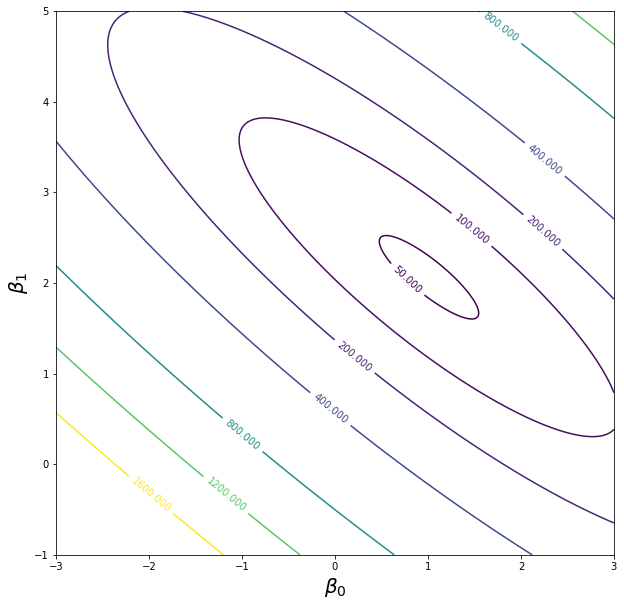

In [150]:
plotsurface(df)

**Part C**: Now it's time to implement Stochastic Gradient Descent.  Most of the code in the function sgd has been written for you.  Your job is to fill in the values of the partial derivatives in the appropriate places.  Recall that the update scheme is given by 

$$
\begin{eqnarray}
\beta_0 &\leftarrow& \beta_0 - \eta \cdot (-2) \cdot \left[y_i - (\beta_0 + \beta_1x_i) \right] \\
\beta_1 &\leftarrow& \beta_1 - \eta \cdot (-2) \cdot \left[y_i - (\beta_0 + \beta_1x_i) \right] x_i\\
\end{eqnarray}
$$

Note that the function parameter beta is a numpy array containing the initial guess for the solve. The numpy array bhist stores the approximation of the betas after each iteration for plotting purposes.  

beta_0 = 1.01202, beta_1 = 2.06617


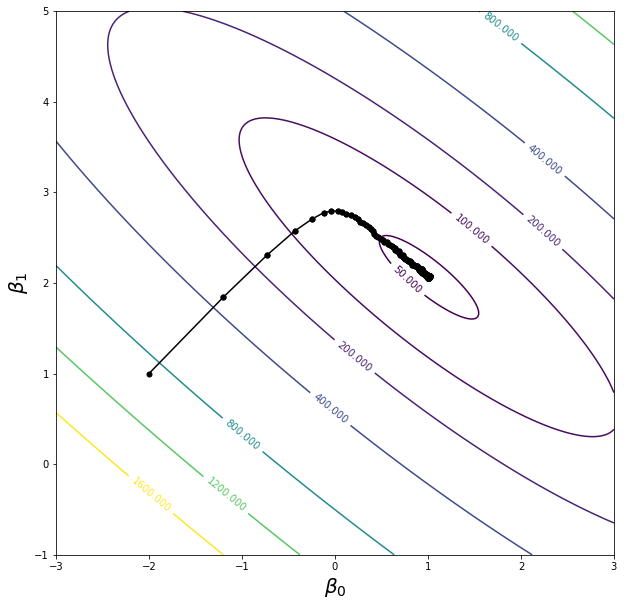

In [154]:
def sgd(df, beta, eta=0.1, num_epochs=100):
    bhist = np.zeros((num_epochs+1, 2))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    for ee in range(1,num_epochs+1):
        shuffled_inds = list(range(len(df)))
        np.random.shuffle(shuffled_inds)
        for ii in shuffled_inds:
            xi = df.loc[ii,"x"]
            yi = df.loc[ii,"y"]
            mui = -2*(yi - (beta[0] + beta[1]*xi))
            beta[0] = beta[0] - eta * mui 
            beta[1] = beta[1] - eta * mui * xi 
        bhist[ee,:] = beta
    return bhist 

beta_start = np.array([-2.0, 1.0])
bhist = sgd(df, beta=beta_start, eta=0.0025, num_epochs=200)
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(df, bhist=bhist)

**Part D**: Experiment with the value of the learning rate $\eta$ and the number of epochs.  When you think you have tuned your settings, compare the parameters $\beta_0$ and $\beta_1$ determined by the solver with those returned by sm.OLS.   


### Exercise 2: Stochastic Gradient Descent for Logistic Regression 
***

In this exercise we will implement Stochastic Gradient Descent to learn the parameters of a logistic regression with a single feature.  The following code generates and plots the data.  

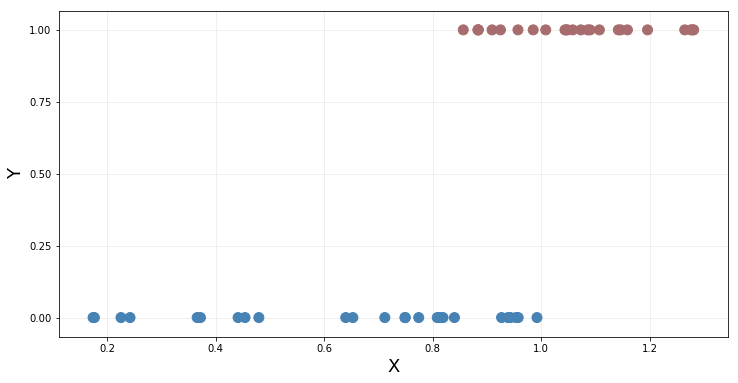

In [221]:
np.random.seed(1235)
x1, x2 = stats.uniform.rvs(0,1.0,size=25), 0.8 + .5*stats.uniform.rvs(size=25)
y1, y2 = np.zeros(25), np.ones(25)
x, y = np.array(list(x1)+list(x2)), np.array(list(y1) + list(y2))
df = pd.DataFrame({"x": x, "y": y})
df.head()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
ax.scatter(df["x"], df["y"], s=100, color=colors)
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_xlabel("X", fontsize=18)
ax.set_ylabel("Y", fontsize=18)
plt.yticks([0,.25, .5, .75, 1]);

**Part A**: Let's start off by estimating the parameters in the logistic regression model using statsmodels so we can check our results. 

In [222]:
X = df["x"].values.reshape(-1,1)
X = sm.add_constant(X)
logreg = sm.Logit(df["y"], X).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.291713
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Dec 2017   Pseudo R-squ.:                  0.5791
Time:                        01:07:36   Log-Likelihood:                -14.586
converged:                       True   LL-Null:                       -34.657
                                        LLR p-value:                 2.360e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.4751      5.008     -3.090      0.002     -25.291      -5.659
x1            16.9537      5.393      3.144      0.002       6.384      27.524
==============================================================================
"""

**Part B**: The next thing we'll do is visualize the surface of the SSE, of which we're attempting to find the minimum. Does it looks like the parameters reported by sm.OLS lie at the bottom of the SSE surface?  

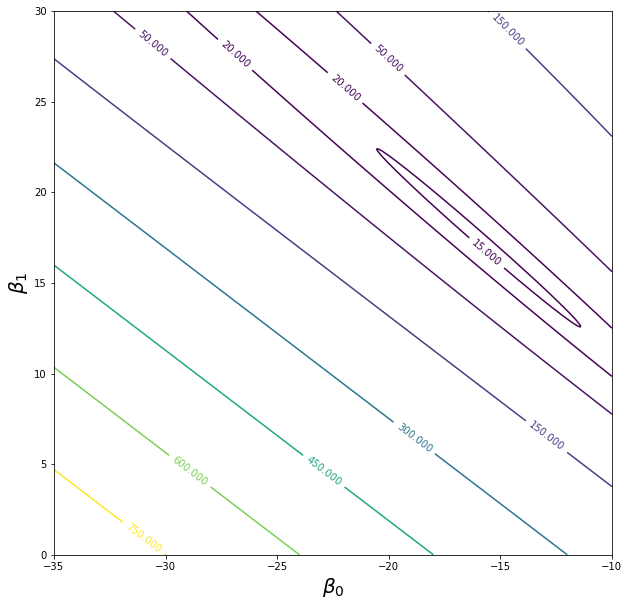

In [256]:
plotlogregsurface(df)

**Part C**: Now it's time to implement Stochastic Gradient Descent.  Most of the code in the function sgd has been written for you.  Your job is to fill in the values of the partial derivatives in the appropriate places.  Recall that the update scheme is given by 

$$
\begin{eqnarray}
\beta_0 &\leftarrow& \beta_0 - \eta \cdot \left(-\left[y_i - \textrm{sigm}(\beta_0 + \beta_1x_i) \right]\right) \\
\beta_1 &\leftarrow& \beta_1 - \eta \cdot \left(-\left[y_i - \textrm{sigm}(\beta_0 + \beta_1x_i) \right] x_i\right)
\end{eqnarray}
$$

Note that the function parameter beta is a numpy array containing the initial guess for the solve. The numpy array bhist stores the approximation of the betas after each iteration for plotting purposes.  

beta_0 = -15.51818, beta_1 = 16.94200


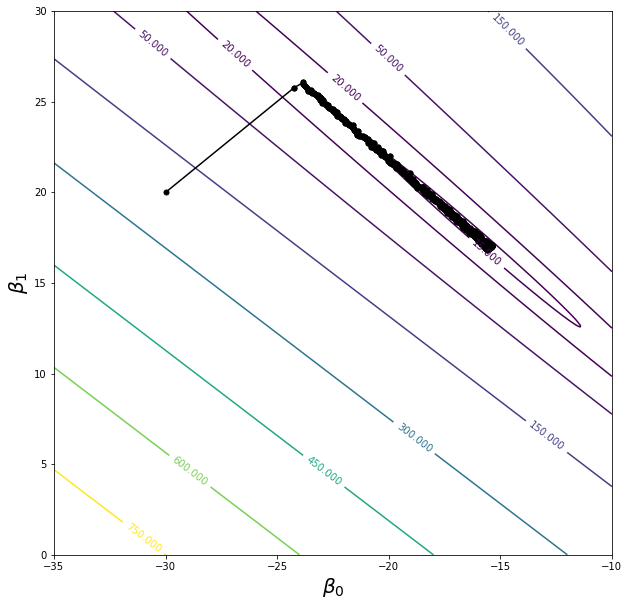

In [254]:
def sgd_logreg(df, beta, eta=0.1, num_epochs=100):
    bhist = np.zeros((num_epochs+1, 2))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    for ee in range(1,num_epochs+1):
        shuffled_inds = list(range(len(df)))
        np.random.shuffle(shuffled_inds)
        for ii in shuffled_inds:
            xi = df.loc[ii,"x"]
            yi = df.loc[ii,"y"]
            mui = -(yi - sigm(beta[0] + beta[1]*xi))
            beta[0] = beta[0] - eta * mui 
            beta[1] = beta[1] - eta * mui * xi 
        bhist[ee,:] = beta
    return bhist 

beta_start = np.array([-30.0, 20.0])
bhist = sgd_logreg(df, beta=beta_start, eta=0.10, num_epochs=7500)
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotlogregsurface(df, bhist=bhist[::5])

### Helper Functions
***

In [255]:
mycolors = {"blue":"steelblue", "red":"#a76c6e",  "green":"#6a9373", "smoke":"#f2f2f2"}

def eval_SSE(df, b0, b1):
    sse = 0 
    for ii in range(len(df)):
        xi = df.loc[ii,"x"]
        yi = df.loc[ii,"y"]
        sse += (yi - (b0 + b1*xi))**2
    return sse

def plotsurface(df, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-1, 5, 300))
    Z = eval_SSE(df, xx, yy)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    levels = [50, 100, 200] + list(range(400,2000,400))
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlim([-3,3])
    ax.set_ylim([-1,5])
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0,y1], color="black", marker="o", lw=1.5, markersize=5)
            
def sigm(z):
    return 1 / (1 + np.exp(-z))

def eval_NLL(df, b0, b1):
    nll = 0 
    for ii in range(len(df)):
        xi = df.loc[ii,"x"]
        yi = df.loc[ii,"y"]
        nll -= yi * np.log(sigm(b0+b1*xi)) + (1-yi)*np.log(1-sigm(b0+b1*xi))
    return nll

def plotlogregsurface(df, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-35, -10, 300), np.linspace(0, 30, 300))
    Z = eval_NLL(df, xx, yy)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    levels = [15, 20, 50] + [150, 300, 450, 600, 750]
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0,y1], color="black", marker="o", lw=1.5, markersize=5)